# Bias Voltage Setting Demo
This is a demonstration of the software tool that assists with bias voltage setting during the optical streak camera calibration process.

It finds the first and last *n* peaks of a streaked comb pulse, then calculates the spacing between the peaks. The difference between the spacing of the first and last *n* peaks is calculated as a measure of sweep linearity.

The bias voltage is adjusted until the difference calculation is approximately zero.

A plot of the lineout from which the calculations are taken highlights the peaks that were used for the calculation for the user to verify the correct peaks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import find_peaks

The user-defined paramters allow the user to:
- Choose minimum height of peaks to count
- Choose minimum distance between peaks
- Choose how many peaks to count on each side (num_peaks)
- Choose to skip every *n* peaks
- Choose how many peaks to skip on either side
- Define swath size

In [2]:
# User-defined parameters:

# name of saved image
filename = 'TIF/40ns_1GHz.TIF'
# define minimum height of peaks
min_height = 5000
# define minimum distance between peaks
min_distance = 3
# define number of peaks to count on each side
num_peaks = 5
# define peaks to skip
skip_peaks_left = 0
skip_peaks_right = 0
every_n_peaks = 1
# define swath size (in pixels)
swath_size = 10

In [3]:
# find the optimal swath lineout of an image
def best_lineout(image, min_p, min_h, min_d):
    # find all suitable lineouts
    lineout_index = []
    peaks_list = []
    for i in range(len(image)-swath_size):
        # find peaks in each lineout with previously defined parameters
        swath = np.mean(img[i:i+swath_size], axis=0)
        peaks, _ = find_peaks(swath, height=min_h, distance=min_d)
        if len(peaks) > min_p*2:
            lineout_index.append(i)
            peaks_list.append(peaks)
    # find optimal swath lineout (most peaks within criteria)
    max_peaks = 0
    best_swath = -1
    for i in range(len(peaks_list)):
        if len(peaks_list[i]) > max_peaks:
            max_peaks = len(peaks_list[i])
            best_swath = lineout_index[i]
    # return the starting index of the best swath lineout
    # if no suitable lineout found, return -1
    return best_swath

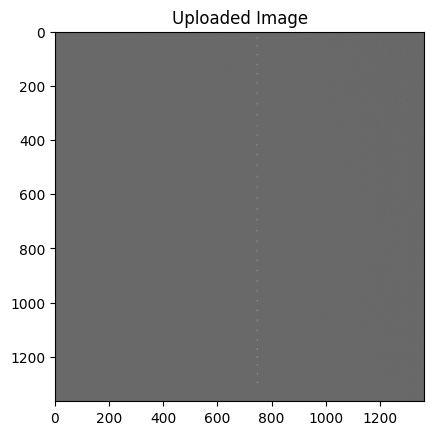

In [4]:
# import image data
fimg = Image.open(filename)
img = np.array(fimg)
plt.imshow(img, cmap="grey")
plt.title("Uploaded Image")
plt.show()

In [5]:
# minimum number of peaks needed based on user-defined parameters
min_peaks = 2*num_peaks*every_n_peaks + skip_peaks_left + skip_peaks_right
print("Minimum number of peaks needed:", min_peaks)

Minimum number of peaks needed: 10


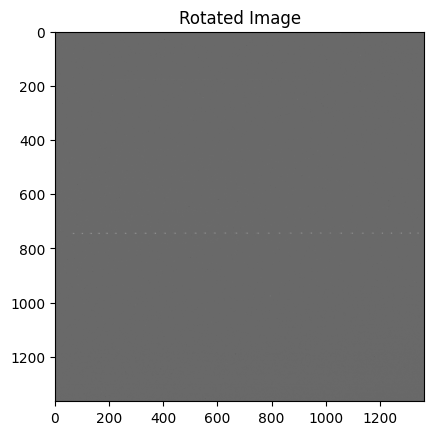

In [6]:
# find starting index of the best swath lineout
swath_start = best_lineout(img, min_peaks, min_height, min_distance)
# if none found, rotate image and try again
if swath_start == -1:
    img = np.rot90(img, axes=(1,0))
    swath_start = best_lineout(img, min_peaks, min_height, min_distance)
    if swath_start != -1:
        plt.imshow(img, cmap="grey")
        plt.title("Rotated Image")
        plt.show()
# if none found still, raise an exception
if swath_start == -1:
    raise ValueError("Image cannot be evaluated. Please choose another image.")

In [7]:
# get lineout of swath
lineout = np.mean(img[swath_start:swath_start+swath_size], axis=0)

# find peaks at best line with previously defined parameters
peaks, _ = find_peaks(lineout, height=min_height, distance=min_distance)

# keep track of peaks counted
peaks_counted = []

In [8]:
# find spacing on left
avg_space_left = 0
for i in range(0, (num_peaks-1)*every_n_peaks, every_n_peaks):
    # define starting point for counting peaks
    st = i + skip_peaks_left
    # ensure enough peaks exist after skipping
    if st + every_n_peaks >= len(peaks):
        raise ValueError("Too many peaks skipped. Please redefine your parameters.")
    avg_space_left += peaks[st+every_n_peaks] - peaks[st]
    # keep track of peaks counted
    if i == 0:
        peaks_counted.append(peaks[st])
    peaks_counted.append(peaks[st+every_n_peaks])
avg_space_left /= (num_peaks - 1)
print("Average space on left:", avg_space_left)

Average space on left: 30.75


In [9]:
# find spacing on right
avg_space_right = 0
for i in reversed(range(0, (num_peaks-1)*every_n_peaks, every_n_peaks)):
    # define starting point for counting peaks
    st = -i - skip_peaks_right - 1
    # ensure enough peaks exist after skipping
    if st - every_n_peaks < -len(peaks):
        raise ValueError("Too many peaks skipped. Please redefine your parameters.")
    avg_space_right += peaks[st] - peaks[st-every_n_peaks]
    # keep track of peaks counted
    peaks_counted.append(peaks[st-every_n_peaks])
    if i == 0:
        peaks_counted.append(peaks[st])
avg_space_right /= (num_peaks - 1)
print("Average space on right:", avg_space_right)

Average space on right: 32.75


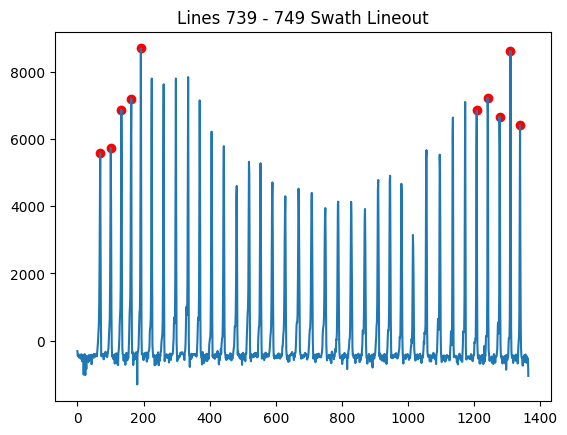

In [10]:
# plot the comb pulses (line-out)
plt.plot(lineout)
# highlight the peaks counted
plt.scatter(peaks_counted, lineout[peaks_counted], color='r')

if swath_size > 1:
    plt.title("Lines {} - {} Swath Lineout".format(swath_start, swath_start+swath_size))
else:
    plt.title("Line {} Lineout".format(swath_start))
plt.show()

In [11]:
# find difference in spacing
print("Difference in spacing:", avg_space_left - avg_space_right)
print("Left peak {} pixels from edge, right peak {} pixels from edge.".format(peaks_counted[0], len(lineout) - peaks_counted[-1]))


Difference in spacing: -2.0
Left peak 69 pixels from edge, right peak 26 pixels from edge.


Now that we have a measure of the sweep linearity (difference in spacing), we can adjust our bias voltage setting until the measure is nearly 0.